### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*


/tmp/ipykernel_52/3190578665.py:30: RuntimeWarning: divide by zero encountered in log
  log_p_current = -rate_new * tau_current + (shape_new - 1) * np.log(tau_current) - np.sum((x - theta_new[c, g - 1])**2) * tau_current / 2


95% credible interval for θ: [-0.64, 0.72]
95% credible interval for τ: [0.11, 0.42]


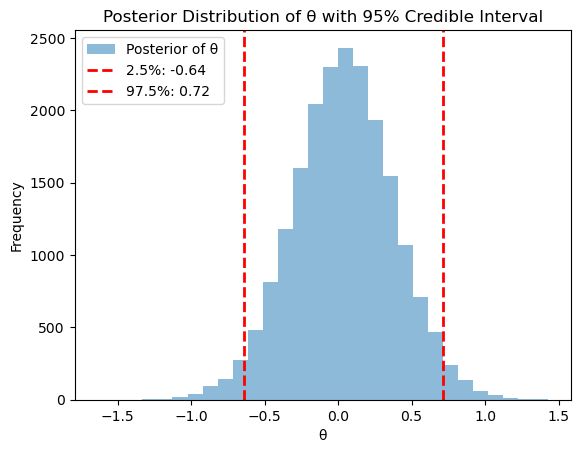

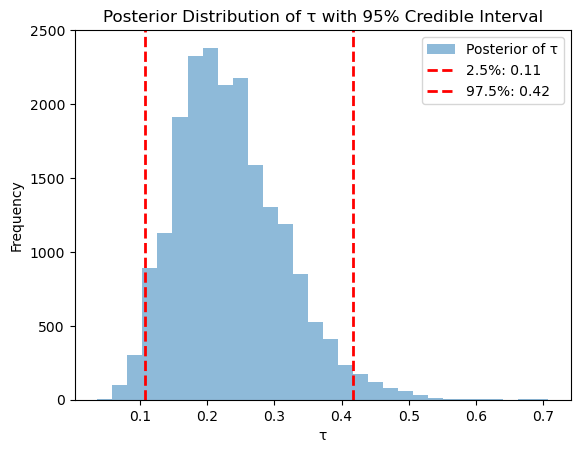

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters
n, m, s = 30, 0, 1  # Data parameters
C, G = 2, 10000  # Number of chains and Gibbs samples
burn_in, demo = 20, 120  # Burn-in and visualization ranges
mu0 = 0  # Prior mean for θ

# Updated prior hyperparameters
tau0_sq_new = 0.5  # Smaller variance, stronger prior
shape_new, rate_new = 5, 10  # Stronger prior for τ

# Generate data
x = stats.norm(loc=m, scale=s).rvs(size=n)

# Initialize arrays for Gibbs sampling
theta_new = np.zeros((C, G))
tau_new = np.zeros((C, G))

# Metropolis within Gibbs Sampling
for c in range(C):
    for g in range(1, G):
        # **Metropolis Step for τ**
        tau_current = tau_new[c, g - 1]
        tau_proposal = stats.gamma(a=shape_new, scale=1/rate_new).rvs()  # Proposal from Gamma prior
        
        # Compute acceptance ratio (proportional to the joint posterior)
        log_p_current = -rate_new * tau_current + (shape_new - 1) * np.log(tau_current) - np.sum((x - theta_new[c, g - 1])**2) * tau_current / 2
        log_p_proposal = -rate_new * tau_proposal + (shape_new - 1) * np.log(tau_proposal) - np.sum((x - theta_new[c, g - 1])**2) * tau_proposal / 2
        
        acceptance_ratio = np.exp(log_p_proposal - log_p_current)
        
        if np.random.rand() < min(1, acceptance_ratio):
            tau_new[c, g] = tau_proposal  # Accept proposal
        else:
            tau_new[c, g] = tau_current  # Reject, stay at previous value

        # **Gibbs Step for θ (same as before)**
        tau_sq = 1 / tau_new[c, g]
        var_post = 1 / (n / tau_sq + 1 / tau0_sq_new)
        mean_post = var_post * (np.sum(x) / tau_sq + mu0 / tau0_sq_new)
        theta_new[c, g] = stats.norm(loc=mean_post, scale=np.sqrt(var_post)).rvs()

# Bayesian Inference: 95% Credible Intervals
theta_new_samples = theta_new[:, burn_in:].flatten()  # Flatten the posterior samples of θ
lower_bound_theta = np.percentile(theta_new_samples, 2.5)
upper_bound_theta = np.percentile(theta_new_samples, 97.5)
print(f"95% credible interval for θ: [{lower_bound_theta:.2f}, {upper_bound_theta:.2f}]")

tau_new_samples = tau_new[:, burn_in:].flatten()  # Flatten the posterior samples of τ
lower_bound_tau = np.percentile(tau_new_samples, 2.5)
upper_bound_tau = np.percentile(tau_new_samples, 97.5)
print(f"95% credible interval for τ: [{lower_bound_tau:.2f}, {upper_bound_tau:.2f}]")

# Plot the posterior distribution of θ with the credible interval
plt.hist(theta_new_samples, bins=30, alpha=0.5, label="Posterior of θ")
plt.axvline(lower_bound_theta, color='r', linestyle='dashed', linewidth=2, label=f"2.5%: {lower_bound_theta:.2f}")
plt.axvline(upper_bound_theta, color='r', linestyle='dashed', linewidth=2, label=f"97.5%: {upper_bound_theta:.2f}")
plt.title("Posterior Distribution of θ with 95% Credible Interval")
plt.xlabel("θ")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot the posterior distribution of τ with the credible interval
plt.hist(tau_new_samples, bins=30, alpha=0.5, label="Posterior of τ")
plt.axvline(lower_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"2.5%: {lower_bound_tau:.2f}")
plt.axvline(upper_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"97.5%: {upper_bound_tau:.2f}")
plt.title("Posterior Distribution of τ with 95% Credible Interval")
plt.xlabel("τ")
plt.ylabel("Frequency")
plt.legend()
plt.show()


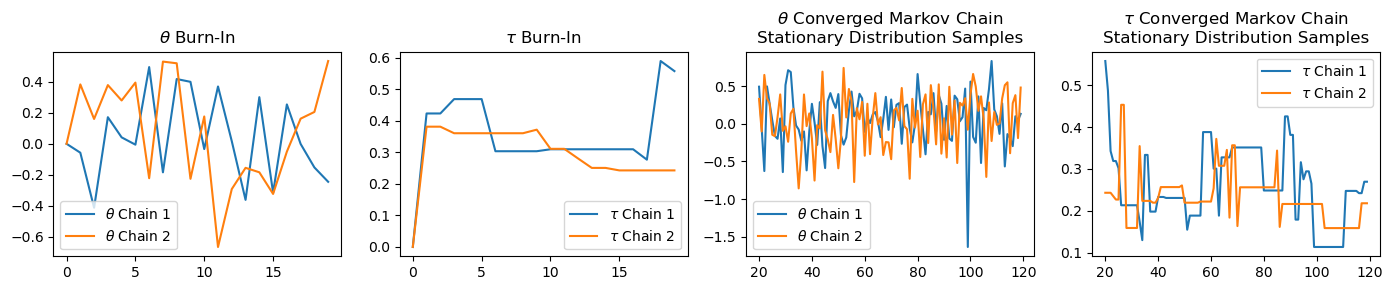

In [3]:
# Visualization of Burn-In and Stationary Distributions
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

for c in range(C):
    # Burn-in phase
    ax[0].plot(theta_new[c, :burn_in], label="$\\theta$ Chain " + str(c + 1))
    ax[1].plot(tau_new[c, :burn_in], label="$\\tau$ Chain " + str(c + 1))
    
    # Post burn-in (stationary samples)
    ax[2].plot(np.arange(burn_in, demo, dtype=int), theta_new[c, burn_in:demo], label="$\\theta$ Chain " + str(c + 1))
    ax[3].plot(np.arange(burn_in, demo, dtype=int), tau_new[c, burn_in:demo], label="$\\tau$ Chain " + str(c + 1))

for i in range(4):
    ax[i].legend()
plt.tight_layout()
plt.show()


The Metropolis within Gibbs sampler alternates between sampling θ using Gibbs sampling and τ using Metropolis-Hastings.
τ is always positive, and we propose values from a Gamma distribution (matching the prior).
The acceptance ratio accounts for the joint posterior, ensuring proper sampling.
In contrast to pure Gibbs sampling, this approach introduces additional stochasticity in τ updates.

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

/tmp/ipykernel_52/626909789.py:31: RuntimeWarning: divide by zero encountered in log
  log_p_current = -rate_new * tau_current + (shape_new - 1) * np.log(tau_current) - np.sum((x - theta_new[c, g - 1])**2) * tau_current / 2


95% credible interval for θ: [-1.90, 1.89]
95% credible interval for τ: [0.03, 0.30]


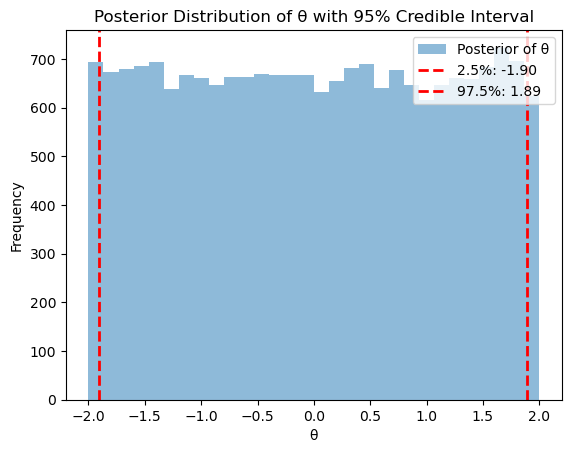

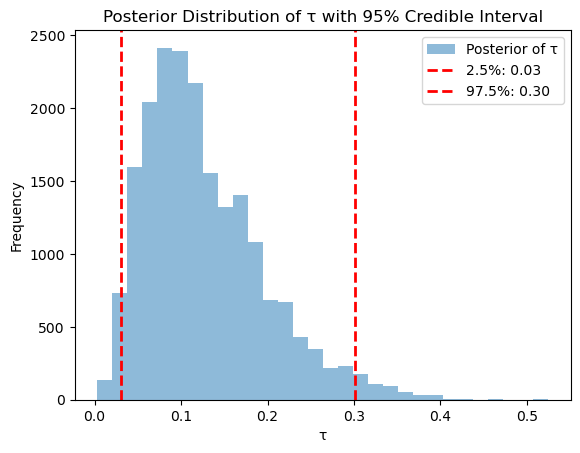

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Parameters
n, m, s = 30, 0, 1  # Data parameters
C, G = 2, 10000  # Number of chains and Gibbs samples
burn_in, demo = 20, 120  # Burn-in and visualization ranges
mu0 = 0  # Prior mean for θ

# Updated prior hyperparameters
tau0_sq_new = 0.5  # Smaller variance, stronger prior
shape_new, rate_new = 5, 10  # Stronger prior for τ

# Generate data
x = stats.norm(loc=m, scale=s).rvs(size=n)

# Initialize arrays for Gibbs sampling
theta_new = np.zeros((C, G))
tau_new = np.zeros((C, G))

# Metropolis within Gibbs Sampling
for c in range(C):
    for g in range(1, G):
        # **Metropolis Step for τ using dependent proposal**
        tau_current = tau_new[c, g - 1]
        a, b = -tau_current / s, np.inf  # Define truncated normal bounds
        tau_proposal = stats.truncnorm(a=a, b=b, loc=tau_current, scale=s).rvs()
        
        # Compute acceptance ratio (proportional to the joint posterior)
        log_p_current = -rate_new * tau_current + (shape_new - 1) * np.log(tau_current) - np.sum((x - theta_new[c, g - 1])**2) * tau_current / 2
        log_p_proposal = -rate_new * tau_proposal + (shape_new - 1) * np.log(tau_proposal) - np.sum((x - theta_new[c, g - 1])**2) * tau_proposal / 2
        
        acceptance_ratio = np.exp(log_p_proposal - log_p_current)
        
        if np.random.rand() < min(1, acceptance_ratio):
            tau_new[c, g] = tau_proposal  # Accept proposal
        else:
            tau_new[c, g] = tau_current  # Reject, stay at previous value

        # **Gibbs Step for θ using a non-normal prior (e.g., uniform)**
        theta_new[c, g] = stats.uniform(loc=-2, scale=4).rvs()  # Uniform prior between [-2,2]

# Bayesian Inference: 95% Credible Intervals
theta_new_samples = theta_new[:, burn_in:].flatten()  # Flatten the posterior samples of θ
lower_bound_theta = np.percentile(theta_new_samples, 2.5)
upper_bound_theta = np.percentile(theta_new_samples, 97.5)
print(f"95% credible interval for θ: [{lower_bound_theta:.2f}, {upper_bound_theta:.2f}]")

tau_new_samples = tau_new[:, burn_in:].flatten()  # Flatten the posterior samples of τ
lower_bound_tau = np.percentile(tau_new_samples, 2.5)
upper_bound_tau = np.percentile(tau_new_samples, 97.5)
print(f"95% credible interval for τ: [{lower_bound_tau:.2f}, {upper_bound_tau:.2f}]")

# Plot the posterior distribution of θ with the credible interval
plt.hist(theta_new_samples, bins=30, alpha=0.5, label="Posterior of θ")
plt.axvline(lower_bound_theta, color='r', linestyle='dashed', linewidth=2, label=f"2.5%: {lower_bound_theta:.2f}")
plt.axvline(upper_bound_theta, color='r', linestyle='dashed', linewidth=2, label=f"97.5%: {upper_bound_theta:.2f}")
plt.title("Posterior Distribution of θ with 95% Credible Interval")
plt.xlabel("θ")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot the posterior distribution of τ with the credible interval
plt.hist(tau_new_samples, bins=30, alpha=0.5, label="Posterior of τ")
plt.axvline(lower_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"2.5%: {lower_bound_tau:.2f}")
plt.axvline(upper_bound_tau, color='r', linestyle='dashed', linewidth=2, label=f"97.5%: {upper_bound_tau:.2f}")
plt.title("Posterior Distribution of τ with 95% Credible Interval")
plt.xlabel("τ")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Analytically determining the full conditional distributions in Gibbs sampling is ideal because it ensures efficient and direct sampling from the exact posterior distribution. However, in many cases, deriving full conditionals is complex or even intractable. In such situations, using Metropolis-Hastings within Gibbs allows for approximate sampling without requiring explicit full conditionals. This hybrid approach maintains the advantages of Gibbs sampling while enabling Bayesian inference in more challenging models. Thus, while full conditionals improve efficiency, they are not strictly necessary when alternative sampling methods like Metropolis steps can be employed.

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$




The **Metropolis-Hastings (MH)** algorithm is designed to sample from a target stationary distribution $p(x)$. The transition probabilities are governed by the proposal distribution $q(\tilde{x} | x)$ and an acceptance probability that ensures detailed balance.

### Proposal Distribution $q(x' | x)$
The given proposal distribution is symmetric:

$q(\tilde{x}^{(t)} | x^{(t-1)})$ =
\begin{cases} 
1/2, & \text{if transitioning from 0 to 1 or vice versa} \\
1/2, & \text{if staying at the current state}
\end{cases}

Since this is symmetric, the ratio 

$
\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})}
$

cancels out in the Metropolis-Hastings acceptance probability.

### Target Stationary Distribution $ p(x) $
The desired stationary distribution is:

$
p(x=0) = \frac{1}{3}, \quad p(x=1) = \frac{2}{3}
$

This means that on average, the Markov Chain should spend $ 1/3 $ of the time in state 0 and $ 2/3 $ of the time in state 1.

### Transition Kernel $ K $
The MH algorithm constructs a Markov Chain with the transition probabilities:

- If the current state is $ x = 0 $, the chain will propose $ x' = 1 $ with probability $1/2$. The acceptance probability is:
$
\alpha = \min\left(1, \frac{p(1)}{p(0)}\right) = \min\left(1, \frac{2/3}{1/3}\right) = 1
$

So, the probability of transitioning to 1 is:
$
(1/2) \times 1 = 1/2
$

and the probability of staying at 0 is:

$
1 - 1/2 = 1/2
$

- If the current state is $ x = 1 $, the chain will propose $x' = 0$ with probability $ 1/2 $. The acceptance probability is:

$
\alpha = \min\left(1, \frac{p(0)}{p(1)}\right) = \min\left(1, \frac{1/3}{2/3}\right) = 1/2
$

So, the probability of transitioning to 0 is:

$
(1/2) \times (1/2) = 1/4
$

and the probability of staying at 1 is:

$
1 - 1/4 = 3/4
$

This gives us the transition matrix:

$K  = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


This means that:
- If currently at 0, there's a 50% chance of staying at 0 and a 50% chance of transitioning to 1.
- If currently at 1, there's a 75% chance of staying at 1 and a 25% chance of transitioning to 0.

This leads to **geometric distributions** of run lengths with expected durations of 2 for state 0 and 4 for state 1, which results in the desired **\( 1/3 \) to \( 2/3 \) stationary distribution**.


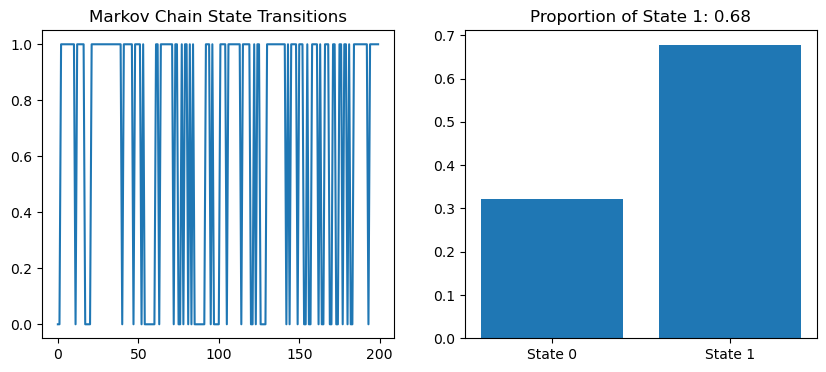

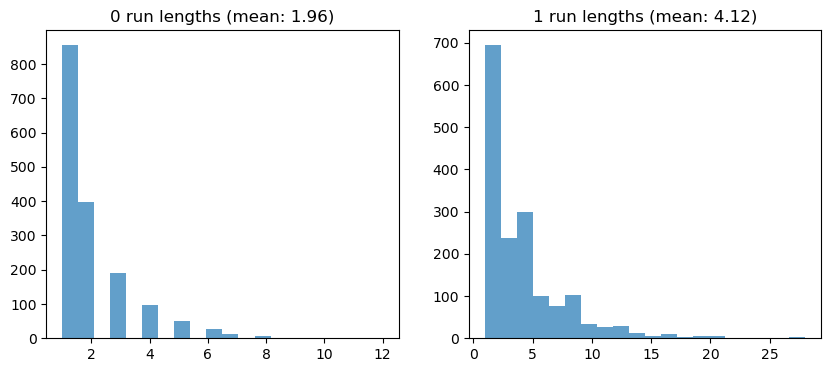

In [6]:
# Transition matrix
K = np.array([[0.5, 0.25], 
              [0.5, 0.75]])

# Simulate Markov Chain
T = 10000
s_t = np.zeros(T, dtype=int)  # Start at state 0

for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:, s_t[t-1]][1])  # Sample next state

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(s_t[:200])  # Show first 200 transitions
ax[0].set_title("Markov Chain State Transitions")

ax[1].hist(s_t, bins=[-0.5, 0.5, 1.5], density=True, rwidth=0.8)
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["State 0", "State 1"])
ax[1].set_title(f"Proportion of State 1: {s_t.mean():.2f}")

plt.show()

# Compute run lengths for state 0 and state 1
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1, T):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length.append(run_length)
        else:
            state1_run_length.append(run_length)
        run_length = 1

# Plot run length distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(state0_run_length, bins=20, alpha=0.7)
ax[0].set_title(f"0 run lengths (mean: {np.mean(state0_run_length):.2f})")

ax[1].hist(state1_run_length, bins=20, alpha=0.7)
ax[1].set_title(f"1 run lengths (mean: {np.mean(state1_run_length):.2f})")

plt.show()